In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

In [2]:
data_path = "datasets/liver-immune-cells-human-liver-10XV2.loom"
adata = sc.read_loom(data_path)
adata.shape

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(105752, 58347)

In [3]:
adata.var_names_make_unique()
adata.obs_names_make_unique()


/home/kevin/anaconda3/envs/scproject/lib/python3.6/site-packages/anndata/utils.py:117: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  + str(example_colliding_values)


In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

... storing 'input_id' as categorical
... storing 'gene_names' as categorical


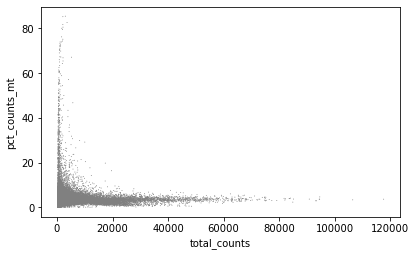

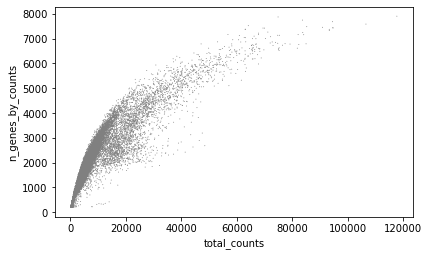

In [5]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [6]:
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]
adata.raw = adata
adata.shape

(34395, 29514)

# Normalizing and scaling

In [7]:
# normalization and scaling
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, subset=True)
sc.pp.scale(adata, max_value=10)

# UMAP and clustering

In [ ]:
# PCA and UMAP
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

In [ ]:
# Perform clustering
sc.tl.leiden(adata, resolution=0.1)

In [ ]:
# Plot stuff
sc.pl.umap(adata, color=['leiden'], legend_loc="on data", palette="Set1", add_outline=True)

In [ ]:
markers = {'HEP': ['TF', 'ORM2', 'HP', 'ORM1', 'KNG1'],
          'Endothelial': ['FCN2', 'FCN3', 'AKAP12', 'PLVAP'],
          'Chlangyocytes': ['CXCL8', 'KRT7'],
          'Bcells': ['MS4A1']}
sc.pl.dotplot(adata, markers, groupby='leiden', log=True)

In [ ]:
markers = {'HSC': ['DCN', 'IGFBP7', 'COLEC11', 'COL1A1'],
          'Lymphoiod': ['RORC', 'PRF1', 'IGKC', 'CD14'],
          'MP': ['C1QB', 'C1QA', 'MSR1', 'HLA-DRA', 'VCAN', 'IL1B'],
          'NKT': ['NKG7', 'CD7','TRAC', 'CD2'],
          'Plasma': ['IGLC2', 'IGHG1', 'SDC1'],
          'Kupffer': ['MAFB', 'VSIG4', 'CD163'],
          'Cycling': ['TOP2A', 'UBE2C', 'RRM2']}
sc.pl.dotplot(adata, markers, groupby='leiden', log=True)

In [ ]:
old_to_new = {
    '0':"NKT",
    '1':"Myeloid",
    '2':"NKT",
    '3':"NKT",
    '4':"Lymphoid",
    '5':"Bcells",
    '6':"NKT",
    '7':"Unknown",
    '8':"Unknown",
}
adata.obs['celltype'] = (
    adata.obs['leiden']
    .map(old_to_new)
    .astype('category')
)

In [ ]:
sc.pl.umap(adata, color="celltype", legend_loc="on data", palette="Set1", add_outline=True)

In [ ]:
adata = adata[adata.obs.celltype != "Unknown",]
adata.shape

In [ ]:
celltypes = adata.obs.celltype
adata = adata.raw.to_adata()

In [ ]:
adata.write("liver_immune_cells_human_liver_labeled.h5ad")